In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
import os
import time
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain_community.vectorstores import Chroma
from langchain.output_parsers import PydanticOutputParser
from sentence_transformers import SentenceTransformer, util
from duckduckgo_search import DDGS

In [9]:
loader=TextLoader('../0.1-Data/pib_news_and_tweets.txt')
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
new_docs=text_splitter.split_documents(documents=docs)
doc_string=[doc.page_content for doc in new_docs]
doc_string

["Yoga Connect 2025: A Hybrid Global Summit on 'Yoga for One Earth, One Health' to be held tomorrow in New Delhi",
 'Union Health Minister Shri J P Nadda virtually inaugurates the 1st edition of Conclave on Best practices organized by the Ministry at AIIMS Nagpur',
 'The Directorate General of Training (DGT) and Shell India jointly launch the Green Skills-focused EV training program to empower youth',
 'Union Public Service Commission Announces Recruitment Results For the month of April 2025\nUnion Public Service Commission (#UPSC) announces Recruitment Results For the month of April 2025',
 '#PIBFactChec…\n📢 #IDY2025: 8⃣ Days to Go!\n\n🧘 This International Day of Yoga, practice Uttana Mandukasana to expand the chest, improve your diaphragmatic movements &amp; boost lung capacity!',
 '#YogaforOneEarthOneHealth #InternationDayofYoga2025 @moayush @MIB_India https://t.co/gmF9xjYSE8']

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings= HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

db=Chroma.from_documents(documents=new_docs,embedding=embeddings)
retriever=db.as_retriever(search_kwargs={"k":2})

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [12]:
class NewsSelectionParser(BaseModel):
    Topic:str=Field(description="selected news")
    Research:str=Field(description='Research behind news')

parser=PydanticOutputParser(pydantic_object=NewsSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected news", "title": "Topic", "type": "string"}, "Research": {"description": "Research behind news", "title": "Research", "type": "string"}}, "required": ["Topic", "Research"]}\n```'

In [13]:
class VaribleState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], operator.add]
    source:str
    retrycount:int


In [14]:
## create a supervisor node
def fun_supervisor(state:VaribleState):
    print("=> Supervisor Call=>")
    question=state["messages"][-1]

    print("Your question is : ", question)

    template="""
    Your task is to classify the given user query into one of the following categories: [News,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    promt=PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )

    chain=promt|model|parser

    response=chain.invoke({"question":question})
    print("Parsed response:", response)
    return {"messages":[response.Topic]}

In [15]:
## create a RAG node
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def fun_RAG(state:VaribleState):
    print("=> RAG Call=>")
    question=state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain=(
        {"context": retriever | format_docs, "question":RunnablePassthrough()}
         |prompt|model|StrOutputParser()
    )
    result=rag_chain.invoke(question)
    return {"messages":[result],"source":"db"}

In [16]:
## create llm  node
def fun_llm(state):
    print("=> LLM Call=>")

    question=state["messages"][0]

    query="Anwer the follow question considering the latest news. Keeps your answer short and in 1 sentennce. Following is the user question: " + question
    response=model.invoke(query)
    return {"messages":[response.content],"source":"llm"}

In [17]:
## create web craller  node

def get_best_duckduckgo_result(query: str) -> str:
    with DDGS() as ddgs:
        results = ddgs.text(query)
        for r in results:
            # Return first non-empty result
            return r["body"]
    return "No results found"


def fun_web(state):
    print("=> WEB Call=>")

    question=state["messages"][0]
    best_result = get_best_duckduckgo_result(question)
    
    return {"messages":[best_result],"source":"web"}

In [18]:
## check gov sources like PIB websites and gov twitter accounts 
import requests
from bs4 import BeautifulSoup
import tweepy

def scrape_pib_releases():
    url = "https://pib.gov.in/allRel.aspx"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    docs = [li.text.strip() for li in soup.select('ul.num li a')]
    return docs

# --- Twitter API Setup ---
def fetch_pib_tweets():
    client = tweepy.Client(bearer_token=os.getenv("X_BEARER_TOKEN"))
    username = "PIB_India"

    try:
        # Get user ID
        user = client.get_user(username=username)
        user_id = user.data.id

        # Fetch recent tweets
        tweets = client.get_users_tweets(id=user_id, max_results=10)
        docs = [tweet.text for tweet in tweets.data] if tweets.data else []
        return docs

    except tweepy.TooManyRequests as e:
        print("Rate limit exceeded. Waiting before retrying...")
        time.sleep(int(e.retry_after) if hasattr(e, 'retry_after') else 60)
        return fetch_pib_tweets()  # Recursive retry
    except Exception as e:
        print(f"Error: {e}")
        return []

def find_semantically_similar_string(target, string_list, threshold=0.5):
    model = SentenceTransformer('all-MiniLM-L6-v2')

    embeddings = model.encode([target] + string_list, convert_to_tensor=True)
    similarities = util.cos_sim(embeddings[0], embeddings[1:])[0]

    matches = []
    for i, score in enumerate(similarities):
        if score >= threshold:
            matches.append((string_list[i], float(score)))
    return matches

def fun_gov(txt):
    print('text to search in gov sources:', txt)
    docs = scrape_pib_releases() + fetch_pib_tweets()

    matches = find_semantically_similar_string(txt, docs)
    print("matches: " , matches)
    return matches
    

In [19]:
## create validator node
def fun_validator(state:VaribleState):
    print("=> Validation Call=>")

    last_msg=state['messages'][-1]
    print("last_msg: ",last_msg)

    source = state["source"]
    retrycount= state["retrycount"]
    result=""
    
    substrings = ["not found", "cannot be answered", "don't know","No results found"]
    if ("db" in source and any(sub in last_msg.lower() for sub in substrings)) or "web" in source:
        matches = fun_gov(state['messages'][0])
        if len(matches) > 0:
            result= "News is real and verified."
        elif retrycount == 1:
            retrycount += 1
            result= "Seems to be a news but its not verified."
        else:
            retrycount += 1
            result="retry"
    
    elif "db" in source and not any(sub in last_msg.lower() for sub in substrings):
        result= "News is real and verified in db."
    
    if "llm" in source:
        result="Seems not a news."

    # substrings = ["not found", "cannot be answered", "don't know","No results found"]
    # if any(sub in text.lower() for sub in substrings):
    #     matches = fun_gov(last_msg)
    #     if len(matches) > 0:
    #         result= "News is real and verified."
    #     else:
    #         retrycount += 1
    #         result="retry"
    # else:
    #     return "Validator Call"


    # source = state["source"]
    # result=""
    
    # if "db" in source:
    #     result= "News is real."
    # if retrycount > 1:
    #     result= "Seems to be a new but its not verified."
    # else:
    #     retrycount += 1
    #     result="retry"

    return {"messages":[result]}

In [20]:
## create web crawler node
def fun_FinalOutput(state:VaribleState):
    print("=> FinalOutput Call=>")
    last_msg=state['messages'][-1]
    print("Here is langgraph decesion: ", last_msg)

In [30]:
def router_supervisor(state:VaribleState):
    print("=> Router_Supervisor =>")

    last_msg=state['messages'][-1]
    print("last message: ", last_msg)

    if "news" in last_msg.lower() and state['retrycount']==0:
        return "Search in DB"
    if "news" in last_msg.lower() and state['retrycount']==1:
        return "Search in web as news is not found in DB"
    else:
        return "Call LLM if question does not seems to be news"

# def router_rag(state:VaribleState):
#     print("=> Router_RAG =>")

#     last_msg=state['messages'][-1]
#     print("last message: ", last_msg)

#     substrings = ["not found", "cannot be answered", "don't know"]
#     if any(sub in text.lower() for sub in substrings):
#         return "WebCrawler Call"
#     else:
#         return "Validator Call"
    
def router_validation(state:VaribleState):
    print("=> Router_Validation =>")

    last_msg=state['messages'][-1]
    print("last message: ", last_msg)

    if "retry" in last_msg.lower():
        return "Validation Failed"
    else:
        return "Validation Pass"

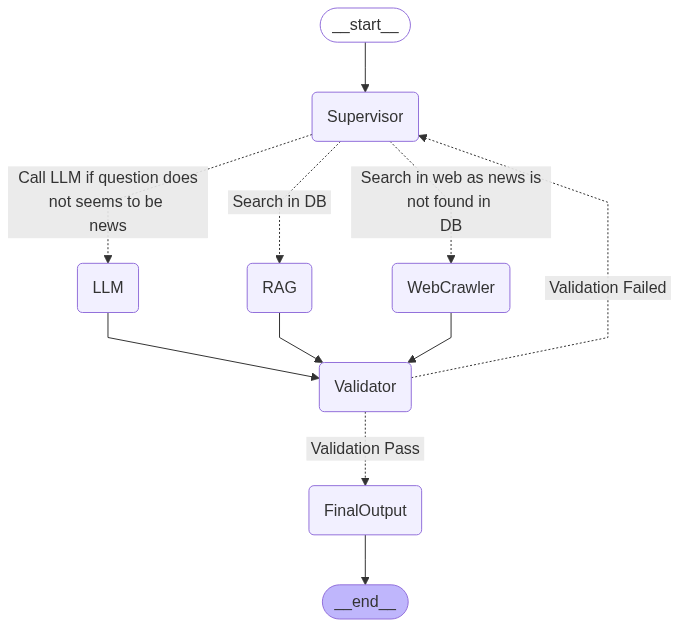

In [31]:
workflow=StateGraph(VaribleState)
workflow.add_node("Supervisor", fun_supervisor)
workflow.add_node("RAG", fun_RAG)
workflow.add_node("LLM", fun_llm)
workflow.add_node("WebCrawler", fun_web)
workflow.add_node("Validator", fun_validator)
workflow.add_node("FinalOutput", fun_FinalOutput)

workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    router_supervisor,
    {
        "Search in DB":"RAG",
        "Search in web as news is not found in DB":"WebCrawler",
        "Call LLM if question does not seems to be news":"LLM"
    }
)
# workflow.add_conditional_edges(
#     "RAG",
#     router_rag,
#     {
#         "WebCrawler Call":"WebCrawler",
#         "Validator Call":"Validator"
#     }
# )
workflow.add_conditional_edges(
    "Validator",
    router_validation,
    {
        "Validation Pass": "FinalOutput",
        "Validation Failed": "Supervisor",  # Loop back
    }
)
workflow.add_edge("RAG", "Validator")
workflow.add_edge("LLM", "Validator")
workflow.add_edge("WebCrawler", "Validator")
workflow.add_edge("FinalOutput", END)

app=workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
state={"messages":["Yoga for One Earth, One Health is in Dehli?"], "retrycount":0, "source":""}

app.invoke(state)

=> Supervisor Call=>
Your question is :  Yoga for One Earth, One Health is in Dehli?
Parsed response: Topic='News' Research="The query asks for information about the location of a specific yoga event or organization ('Yoga for One Earth, One Health') in Delhi.  This suggests a news-related query, seeking factual information about an event or organization's presence in a particular location."
=> Router_Supervisor =>
last message:  News
=> RAG Call=>
=> Validation Call=>
last_msg:  Yes, the Yoga Connect 2025 summit, focusing on "Yoga for One Earth, One Health," is being held in New Delhi.  The event is a hybrid global summit.  More information can be found via the provided link.
=> Router_Validation =>
last message:  News is real and verified in db.
=> FinalOutput Call=>
Here is langgraph decesion:  News is real and verified in db.


{'messages': ['Yoga for One Earth, One Health is in Dehli?',
  'News',
  'Yes, the Yoga Connect 2025 summit, focusing on "Yoga for One Earth, One Health," is being held in New Delhi.  The event is a hybrid global summit.  More information can be found via the provided link.',
  'News is real and verified in db.'],
 'source': 'db',
 'retrycount': 0}

In [24]:
state={"messages":["Plane crash in Gujrat ahmedabad?"], "retrycount":0, "source":""}

app.invoke(state)

=> Supervisor Call=>
Your question is :  Plane crash in Gujrat ahmedabad?
Parsed response: Topic='News' Research='The query is asking for information about a potential plane crash in Gujarat, Ahmedabad.  This is a newsworthy event.'
=> Router_Supervisor =>
last message:  News
=> RAG Call=>
=> Validation Call=>
last_msg:  I don't know.  The provided text is about International Day of Yoga and contains no information about a plane crash in Gujarat, Ahmedabad.
text to search in gov sources: Plane crash in Gujrat ahmedabad?
matches:  [('RT @RamMNK: The Flight Data Recorder (Black Box) has been recovered within 28 hours from the accident site in Ahmedabad by AAIB. This marks…', 0.5936906933784485)]
=> Router_Validation =>
last message:  News is real and verified.
=> FinalOutput Call=>
Here is langgraph decesion:  News is real and verified.


{'messages': ['Plane crash in Gujrat ahmedabad?',
  'News',
  "I don't know.  The provided text is about International Day of Yoga and contains no information about a plane crash in Gujarat, Ahmedabad.",
  'News is real and verified.'],
 'source': 'db',
 'retrycount': 0}

In [25]:
state={"messages":["What is capital for india?"]}

app.invoke(state)

=> Supervisor Call=>
Your question is :  What is capital for india?
Parsed response: Topic='Not Related' Research='This is a general knowledge question, not a news query.'
=> Router_Supervisor =>
last message:  Not Related
=> LLM Call=>
=> Validation Call=>
last_msg:  The capital of India is New Delhi.


KeyError: 'retrycount'